In [1]:
import numpy as np
import matplotlib.pyplot as plt

from rfest import LNP, splineLNP, LNLN, splineLNLN
from rfest import build_design_matrix
from rfest.utils import get_n_samples, split_data, fetch_data, uvec
from rfest.plot import plot_subunits2d, plot_subunits3d, plot2d, plot3d, compare_LNP_and_LNLN

In [2]:
data_liu = fetch_data(4)

(Liu, et al., 2017) is already downloaded. To re-download the same file, please set `overwrite=False`.
Loading data...
Done.


In [3]:
dims = [20, 25, 25]
df = [7,7,7]
dt = 0.033
num_subunits = 4

n_samples = get_n_samples(20, dt) # 20 mins of the full dataset

X = data_liu['train']['X']
y = data_liu['train']['y']
X = build_design_matrix(X[:n_samples], dims[0])
y = y[:n_samples]

(X_train, y_train), (X_dev, y_dev), (X_test, y_test) = split_data(X, y, dt, frac_train=0.5, frac_dev=0.1)

SUMMARY
               N    Minutes   Fraction
Total      36364       20.0        1.0
Train      18182       10.0        0.5
Dev         3636        2.0        0.1
Test       14546        8.0        0.4


In [4]:
r2_nospl_lnp = LNP(X_train, y_train, dims=dims, dt=dt)
r2_nospl_lnp.fit(extra={'X': X_dev, 'y': y_dev}, metric='corrcoef', 
         num_iters=5000, verbose=300, tolerance=10,
         beta=1., step_size=0.1, random_seed=2046,
         fit_history_filter=False)

r2_spl_lnp = splineLNP(X_train, y_train, dims=dims, dt=dt, df=df)
r2_spl_lnp.fit(extra={'X': X_dev, 'y': y_dev}, metric='corrcoef', 
         num_iters=5000, verbose=300, tolerance=10,
         beta=1., step_size=0.1, random_seed=2046,
         fit_history_filter=False)

r2_nospl_lnln = LNLN(X_train, y_train, dims=dims, dt=dt)
r2_nospl_lnln.fit(extra={'X': X_dev, 'y': y_dev}, metric='corrcoef', 
         num_subunits=num_subunits, num_iters=5000, verbose=300, tolerance=10,
         beta=1., step_size=0.1, random_seed=2046,
         fit_history_filter=False)

r2_spl_lnln = splineLNLN(X_train, y_train, dims=dims, dt=dt, df=df)
r2_spl_lnln.fit(extra={'X': X_dev, 'y': y_dev}, metric='corrcoef', 
         num_subunits=num_subunits, num_iters=5000, verbose=300, tolerance=10,
         beta=1., step_size=0.1, random_seed=2046,
         fit_history_filter=False)

Iters	  Time (s)	Cost (train)	Cost (dev)	Metric (train)	Metric (dev)
    0	    23.031	   -76.474	   967.595	     0.689	     0.079
  300	   110.758	 -4075.698	  1001.635	     0.992	     0.135
Stop at 331 steps: cost (train) has been changing less than 1e-5 for 10 steps.

Total time elapsed: 119.805 s.
Iters	  Time (s)	Cost (train)	Cost (dev)	Metric (train)	Metric (dev)
    0	     0.909	   749.499	   141.339	     0.178	     0.115
  300	     6.671	  -985.277	  -121.697	     0.378	     0.290
  600	    15.554	 -1017.081	  -121.728	     0.389	     0.290
  900	    23.307	 -1032.336	  -120.988	     0.394	     0.289
 1200	    31.506	 -1041.592	  -120.630	     0.399	     0.289
Stop at 1319 steps: cost (dev) has been monotonically increasing for 10 steps.

Total time elapsed: 34.867 s.
Iters	  Time (s)	Cost (train)	Cost (dev)	Metric (train)	Metric (dev)
    0	    21.001	  3392.771	   237.889	     0.757	     0.073
  300	   124.038	 -2457.850	   368.256	     0.855	     0.099
Stop at 402 steps: cost

In [16]:
def compare_models(lnp0, lnln0, lnp1, lnln1, X_test, y_test, dt=None, shift=None, title=None, response_type='spike', len_time=1, contour=None, figsize=None):
    
    from rfest.utils import get_spatial_and_temporal_filters
    import matplotlib.gridspec as gridspec
    import warnings
    warnings.filterwarnings("ignore")
    
    dims = lnln1.dims
    dt = lnln1.dt if dt is None else dt
    shift = 0 if shift is None else -shift
    t_tRF = np.linspace(-(dims[0]-shift)*dt, shift*dt, dims[0]+1)[1:]

    fig = plt.figure(figsize=figsize) if figsize is not None else (12,4)
    
    for counter, (lnp, lnln) in enumerate([(lnp0, lnln0), (lnp1, lnln1)]):
        
        (idx0, idx1) = (0, 1) if counter == 0 else (2, 3)

        ws = uvec(lnln.w_opt)
        num_subunits = ws.shape[1]

        sRFs_max = []
        sRFs_min = []
        tRFs = []
        for i in range(num_subunits):
            w = ws[:, i].reshape(dims)
            sRF, tRF = get_spatial_and_temporal_filters(w, dims)

            ref = [sRF[2:, 2:].max(), sRF[2:, 2:].min()][np.argmax([np.abs(sRF.max()), np.abs(sRF.min())])]
            max_coord = np.where(sRF == ref)
            tRF = w[:, max_coord[0], max_coord[1]].flatten()
            tRF_max = np.argmax(tRF)
            sRF_max = w[tRF_max]
            sRFs_max.append(sRF_max)
            tRF_min = np.argmin(tRF)
            sRF_min = w[tRF_min]
            sRFs_min.append(sRF_min)
            tRFs.append(tRF)

        sRFs_max = np.stack(sRFs_max)
        sRFs_min = np.stack(sRFs_min)

        vmax = np.max([np.abs(sRFs_max.max()), np.abs(sRFs_max.min()), np.abs(sRFs_min.max()), np.abs(sRFs_min.min())])

        ncols = num_subunits
        ncols += 2 # add lnp
        nrows = 4

        spec = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig)  
        axs = []
        ax_sRF_mins= []
        ax_sRF_maxs = []    

        # LNP
        w_lnp = uvec(lnp.w_opt).reshape(dims)
        vmax_lnp = np.max([np.abs(w_lnp.max()), np.abs(w_lnp.min())])
        sRF_lnp, tRF_lnp = get_spatial_and_temporal_filters(w_lnp, dims)
        ref = [sRF_lnp[2:, 2:].max(), sRF_lnp[2:, 2:].min()][np.argmax([np.abs(sRF_lnp.max()), np.abs(sRF_lnp.min())])]
        max_coord = np.where(sRF_lnp == ref)
        tRF_lnp = w_lnp[:, max_coord[0], max_coord[1]].flatten()
        tRF_max = np.argmax(tRF_lnp)
        sRF_max = w_lnp[tRF_max]
        tRF_min = np.argmin(tRF_lnp)
        sRF_min = w_lnp[tRF_min]

        ax_sRF_min = fig.add_subplot(spec[idx0, 0])       
        ax_sRF_min.imshow(sRF_min, cmap=plt.cm.bwr, vmax=vmax_lnp, vmin=-vmax_lnp, aspect='auto')
        ax_sRF_min.set_xticks([])
        ax_sRF_min.set_yticks([])
        if counter == 0:
            ax_sRF_min.set_title(f'LNP')

        if counter == 0:
            ax_sRF_min.set_ylabel('No Spline')
        else:
            ax_sRF_min.set_ylabel('Spline')
            
        ax_sRF_mins.append(ax_sRF_min)
        
        ax_tRF = fig.add_subplot(spec[idx1, 0])       
        ax_tRF.plot(t_tRF, tRF_lnp, color='black')
        ax_tRF.spines['top'].set_visible(False)
        ax_tRF.spines['right'].set_visible(False)
#         ax_tRF.set_yticks([])
        ax_tRF.set_xticks([])
#         tRF_max = np.argmax(tRFs[i])
        tRF_min = np.argmin(tRF_lnp)
#         ax_tRF.axvline(t_tRF[tRF_max], color='C3', linestyle='--', alpha=0.6)
        ax_tRF.axvline(t_tRF[tRF_min], color='C0', linestyle='--', alpha=0.6)
        ax_tRF.set_ylim(-0.1, 0.1)
        # LNLN subunits

        for i in range(num_subunits):
            ax_sRF_min = fig.add_subplot(spec[idx0, i+1])       
            ax_sRF_min.imshow(sRFs_min[i], cmap=plt.cm.bwr, vmax=vmax, vmin=-vmax, aspect='auto')
            ax_sRF_min.set_xticks([])
            ax_sRF_min.set_yticks([])
            if i == 0 and counter == 0:
                ax_sRF_min.set_title(f'LNLN')

            ax_sRF_mins.append(ax_sRF_min)
            
            ax_tRF = fig.add_subplot(spec[idx1, i+1])       
            ax_tRF.plot(t_tRF, tRFs[i], color='black')
            ax_tRF.spines['top'].set_visible(False)
            ax_tRF.spines['right'].set_visible(False)
            ax_tRF.set_yticks([]) 
            ax_tRF.set_xticks([])
    #         tRF_max = np.argmax(tRFs[i])
            tRF_min = np.argmin(tRFs[i])
    #         ax_tRF.axvline(t_tRF[tRF_max], color='C3', linestyle='--', alpha=0.6)
            ax_tRF.axvline(t_tRF[tRF_min], color='C0', linestyle='--', alpha=0.6)
            ax_tRF.set_ylim(-0.1, 0.1)


        if contour is not None and counter == 1: # then plot contour

            for i in range(num_subunits+1):

                color_min = 'black' if i == 0 else 'lightsteelblue'
                color_max = 'black' if i == 0 else 'lightcoral'

                ax_sRF_mins[i].contour(sRF_min, levels=[-contour], colors=[color_min], linestyles=['-'], alpha=1)

                for j in range(num_subunits):
                    if i-1 != j:
                        color = 'grey'
                        alpha = 0.5
                        style = '--'                    
                    else:
                        color = 'black'
                        alpha = 1
                        style = '--'
                    ax_sRF_mins[i].contour(sRFs_min[j], levels=[-contour], colors=[color], linestyles=[style], alpha=alpha)
                    
    ax_bar = fig.add_subplot(spec[0, 5])  
    div = int(X_test.shape[0]/4)

    cc_test = np.array([[m.score(X_test[i*div:(i+1)*div], y_test[i*div:(i+1)*div]) for m 
                         in [lnp0, lnp1, lnln0, lnln1]] for i
                         in range(4)])

    cc_test_mean = cc_test.mean(0)
    cc_test_std = cc_test.std(0)
    x = [0, 1, 2, 3]
    ax_bar.bar(x, cc_test_mean, yerr=cc_test_std, width=1, color=['lightblue', 'lightcoral', 'steelblue', 'firebrick'], capsize=5)
    labels = ['LNP', 'LNP (spline)', 'LNLN', 'LNLN (spline)']


    ax_bar.spines['top'].set_visible(False)
    ax_bar.spines['right'].set_visible(False)
    ax_bar.set_xticks(x)
    ax_bar.set_xticklabels(labels, rotation=90)
    ax_bar.set_ylim(0, 0.5)

    plt.subplots_adjust(wspace=0.5)





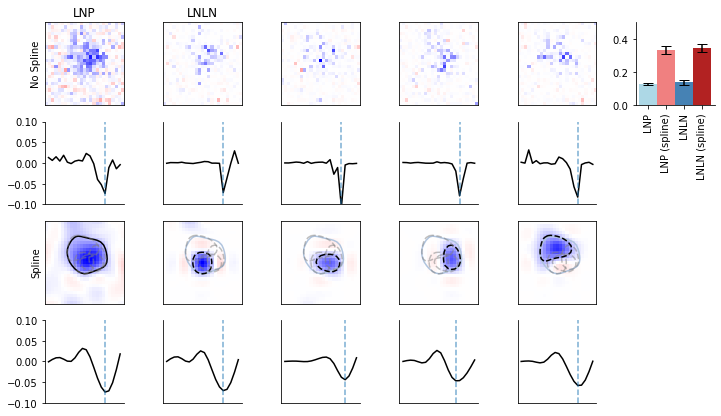

In [17]:
compare_models(r2_nospl_lnp, r2_nospl_lnln, r2_spl_lnp, r2_spl_lnln, X_test, y_test, dt=None, shift=None, contour=0.02,
               figsize=(12, 3.5*2))

plt.savefig('figs/Figure5.pdf')